In [25]:
import pandas as pd
import networkx as nx
import igraph as ig
import leidenalg
import openpyxl
import math
from igraph import *
import matplotlib.pyplot as plt

In [26]:
G = ig.read("gene_gene_interaction_graph.graphml")

In [27]:
def leiden_clustering(graph, cluster_size):
    partition = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, weights='weight', max_comm_size=cluster_size)
    return partition


In [28]:
def check_for_subset(list1, list2):
    set1 = set(list1)
    for sublist in list2:
        set2 = set(sublist)
        if set1.issubset(set2):
            return False
    return True

In [29]:
def perform_clustering(graph, maximum_cluster_size):
    '''
    Performs the main clustering algorithm

    Parameters:
        graph (iGraph graph): The gene-gene interaction graph
        maximum_cluster_size (int): limit cluster hierarchy by setting maximum cluster size

    Returns:
        clusters (list): The resulting clusters
    '''
    
    clusters = []
    for i in range(maximum_cluster_size, 3, -1):
        leiden_partition = leiden_clustering(graph,i)
        for new_clusters in leiden_partition:
            new_clusters = sorted(new_clusters)
            if check_for_subset(new_clusters, clusters):
                clusters.append(new_clusters)
    
    return clusters

In [30]:
def remove_irrelevant_clusters(clusters):
    '''
    Removes clusters that are subset of another cluster and those outside of size 4-100

    Parameters:
        clusters (list): The resulting clusters

    Returns:
        clusters (list): The resulting clusters with irrelevant clusters removed
    '''
    
    clusters = clusters.copy()  # create a copy of the input list
    # Sort the sublists by length in descending order
    clusters.sort(key=len, reverse=True)
    
    i = 0
    while i < len(clusters):
        j = i + 1
        while j < len(clusters):
            # Check if mylist[j] is a subset of mylist[i]
            if set(clusters[j]).issubset(clusters[i]):
                del clusters[j]
            else:
                j += 1
        i += 1
    clusters = [sublist for sublist in clusters if (len(sublist) >= 4  and len(sublist) <= 10)]
    return clusters

In [31]:
clusters = perform_clustering(G,100)
optimal_clusters = remove_irrelevant_clusters(clusters)

In [32]:
print(len(clusters))
print(len(optimal_clusters))

32137
4762


In [33]:
def cluster_weight(graph, cluster):
    '''
    Calculates the weight of a given cluster

    Parameters:
        graph (iGrapgh graph): The gene-gene interaction graph
        cluster (list): A cluster withtin the graph

    Returns:
        weight (int): The sum of the weight of the connecting edges within the cluster
    '''
    
    weight = 0
    for gene_1 in cluster:
        for gene_2 in cluster:
            if graph.are_connected(gene_1, gene_2):
                edge = graph.get_eid(gene_1, gene_2)
                weight += graph.es[edge]["weight"]
    return int(weight/4)

In [34]:
def sort_clusters(clusters):
    '''
    Sorts the clusters by their weight and separates them based on the number of genes within the cluster

    Parameters:
        clusters (list): The resulting clusters

    Returns:
        results (list): List of clusters where each list contains clusters of a certain size
        results_numeric (list): Same as results but nodes are in integer format instead of string
    '''

    # Initialize dictionaries to store the gene clusters and their numeric counterparts.
    gene_clusters = {i: [] for i in range(4, 11)}
    gene_clusters_numeric = {i: [] for i in range(4, 11)}

    for cluster in clusters:
        row, row_numeric = [], []
        for i in range(len(cluster)):
            row.append(G.vs[cluster[i]]["name"])
            row_numeric.append(cluster[i])
        weight = cluster_weight(G, cluster)
        row.append(weight)
        row_numeric.append(weight)

        # Check if the length of the cluster is within the range, then append to appropriate list.
        if 4 <= len(cluster) <= 10:
            gene_clusters[len(cluster)].append(row)
            gene_clusters_numeric[len(cluster)].append(row_numeric)

    results = []
    results_numeric = []

    # Sort and add the clusters to the results lists.
    for i in range(4, 11):
        results.append(sorted(gene_clusters[i], key=lambda x: x[-1], reverse=True))
        results_numeric.append(sorted(gene_clusters_numeric[i], key=lambda x: x[-1], reverse=True))
        
    return results, results_numeric

In [35]:
def save_to_excel(sheets, data, file_name):
    # Create a Pandas Excel writer using openpyxl as the engine.
    writer = pd.ExcelWriter(file_name, engine='openpyxl')

    # Verify that the number of sheets matches the number of data lists
    if len(sheets) != len(data):
        print("Number of sheets and data lists do not match!")
        return

    # Write each DataFrame to a different worksheet.
    for i in range(len(sheets)):
        df = pd.DataFrame(data[i])
        df.to_excel(writer, sheet_name=sheets[i], index=False)

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()

In [36]:
results, results_numeric = sort_clusters(optimal_clusters)

sheets = ['4_genes','5_genes','6_genes','7_genes','8_genes','9_genes','10_genes',]

save_to_excel(sheets, results, "optimal_clusters_sorted.xlsx")

/var/folders/jg/x2tt0_k13g93w287g2tr9c6c0000gn/T/ipykernel_26529/3927075700.py:16: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [37]:
def plot_subgraph(G, nodes):
    # Convert the igraph graph to networkx graph
    G_nx = nx.Graph(G.get_edgelist())

    # Add edge weights and node labels to the networkx graph
    for edge in G.es:
        source, target = edge.source, edge.target
        if source in G_nx and target in G_nx[source]:
            G_nx[source][target]['weight'] = edge['weight']

    for node in G.vs:
        G_nx.nodes[node.index]['name'] = node['name']

    # Generate the subgraph
    subgraph = G_nx.subgraph(nodes)

    # Create the plot
    plt.figure(figsize=(10, 10))
    
    pos = nx.spring_layout(subgraph)
    labels = nx.get_node_attributes(subgraph, 'name')
    weights = nx.get_edge_attributes(subgraph, 'weight')

    for key in weights:
        weights[key] = int(weights[key] / 2)
    
    nx.draw_networkx_nodes(subgraph, pos, node_color='#ADD8E6', node_size=500)
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=12)
    nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=weights)

    plt.axis('off')
    plt.show()

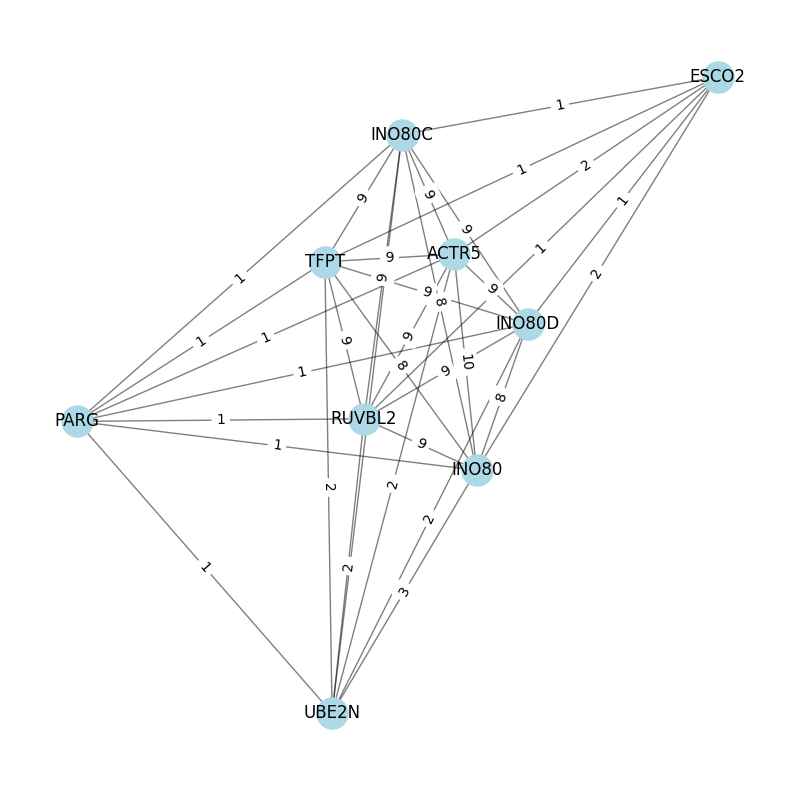

In [38]:
plot_subgraph(G, results_numeric[5][0][:-1])